In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

model_path = '../../../modeling/v5_2/model/'


In [33]:
# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))

def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [34]:
def predict_df(path, nbootstrap=200, percentile=95):

    df = pd.read_csv(path)
    
    ps = []
    ref_fracs = []
    for i in range(nbootstrap):
    
        if i==0:
            data = df.value.values
        else:
            data = np.random.choice(df.value.values, len(df.value.values), replace=True)

        # standardize
        mean = data.mean()
        std = data.std()
        data = (data - mean)/std

        # feature extraction
        features = extract_features(data)

        # predict
        p = model.predict(features[np.newaxis,...], verbose=0)
        p = scalery.inverse_transform(p)[0]
        ref_fracs.append(p[-1])
        if percentile==95:
            p = p[-4] # retrieve the elements corresponding to 0.95 quantile
        elif percentile==99:
            p = p[-2]
        # convert back to original scale
        p *= std
        p += mean
        ps.append(p)
    
    ps = np.array(ps)
    
    return ps.mean(axis=0), np.quantile(ps, 0.025, axis=0), np.quantile(ps, 0.975, axis=0), np.mean(ref_fracs)
    

In [35]:
p95 = predict_df('../preprocessed_data.csv', nbootstrap=1)


In [36]:
p99 = predict_df('../preprocessed_data.csv', nbootstrap=1, percentile=99)


In [37]:
df = pd.read_csv('../preprocessed_data.csv')


In [38]:
p95[-1]


0.9237056

In [39]:
p99[-1]


0.9237056

In [40]:
rrp95 = pd.read_csv('../refineR/all_0.95_no_outlier_removal.csv')
rrp99 = pd.read_csv('../refineR/all_0.99_no_outlier_removal.csv')


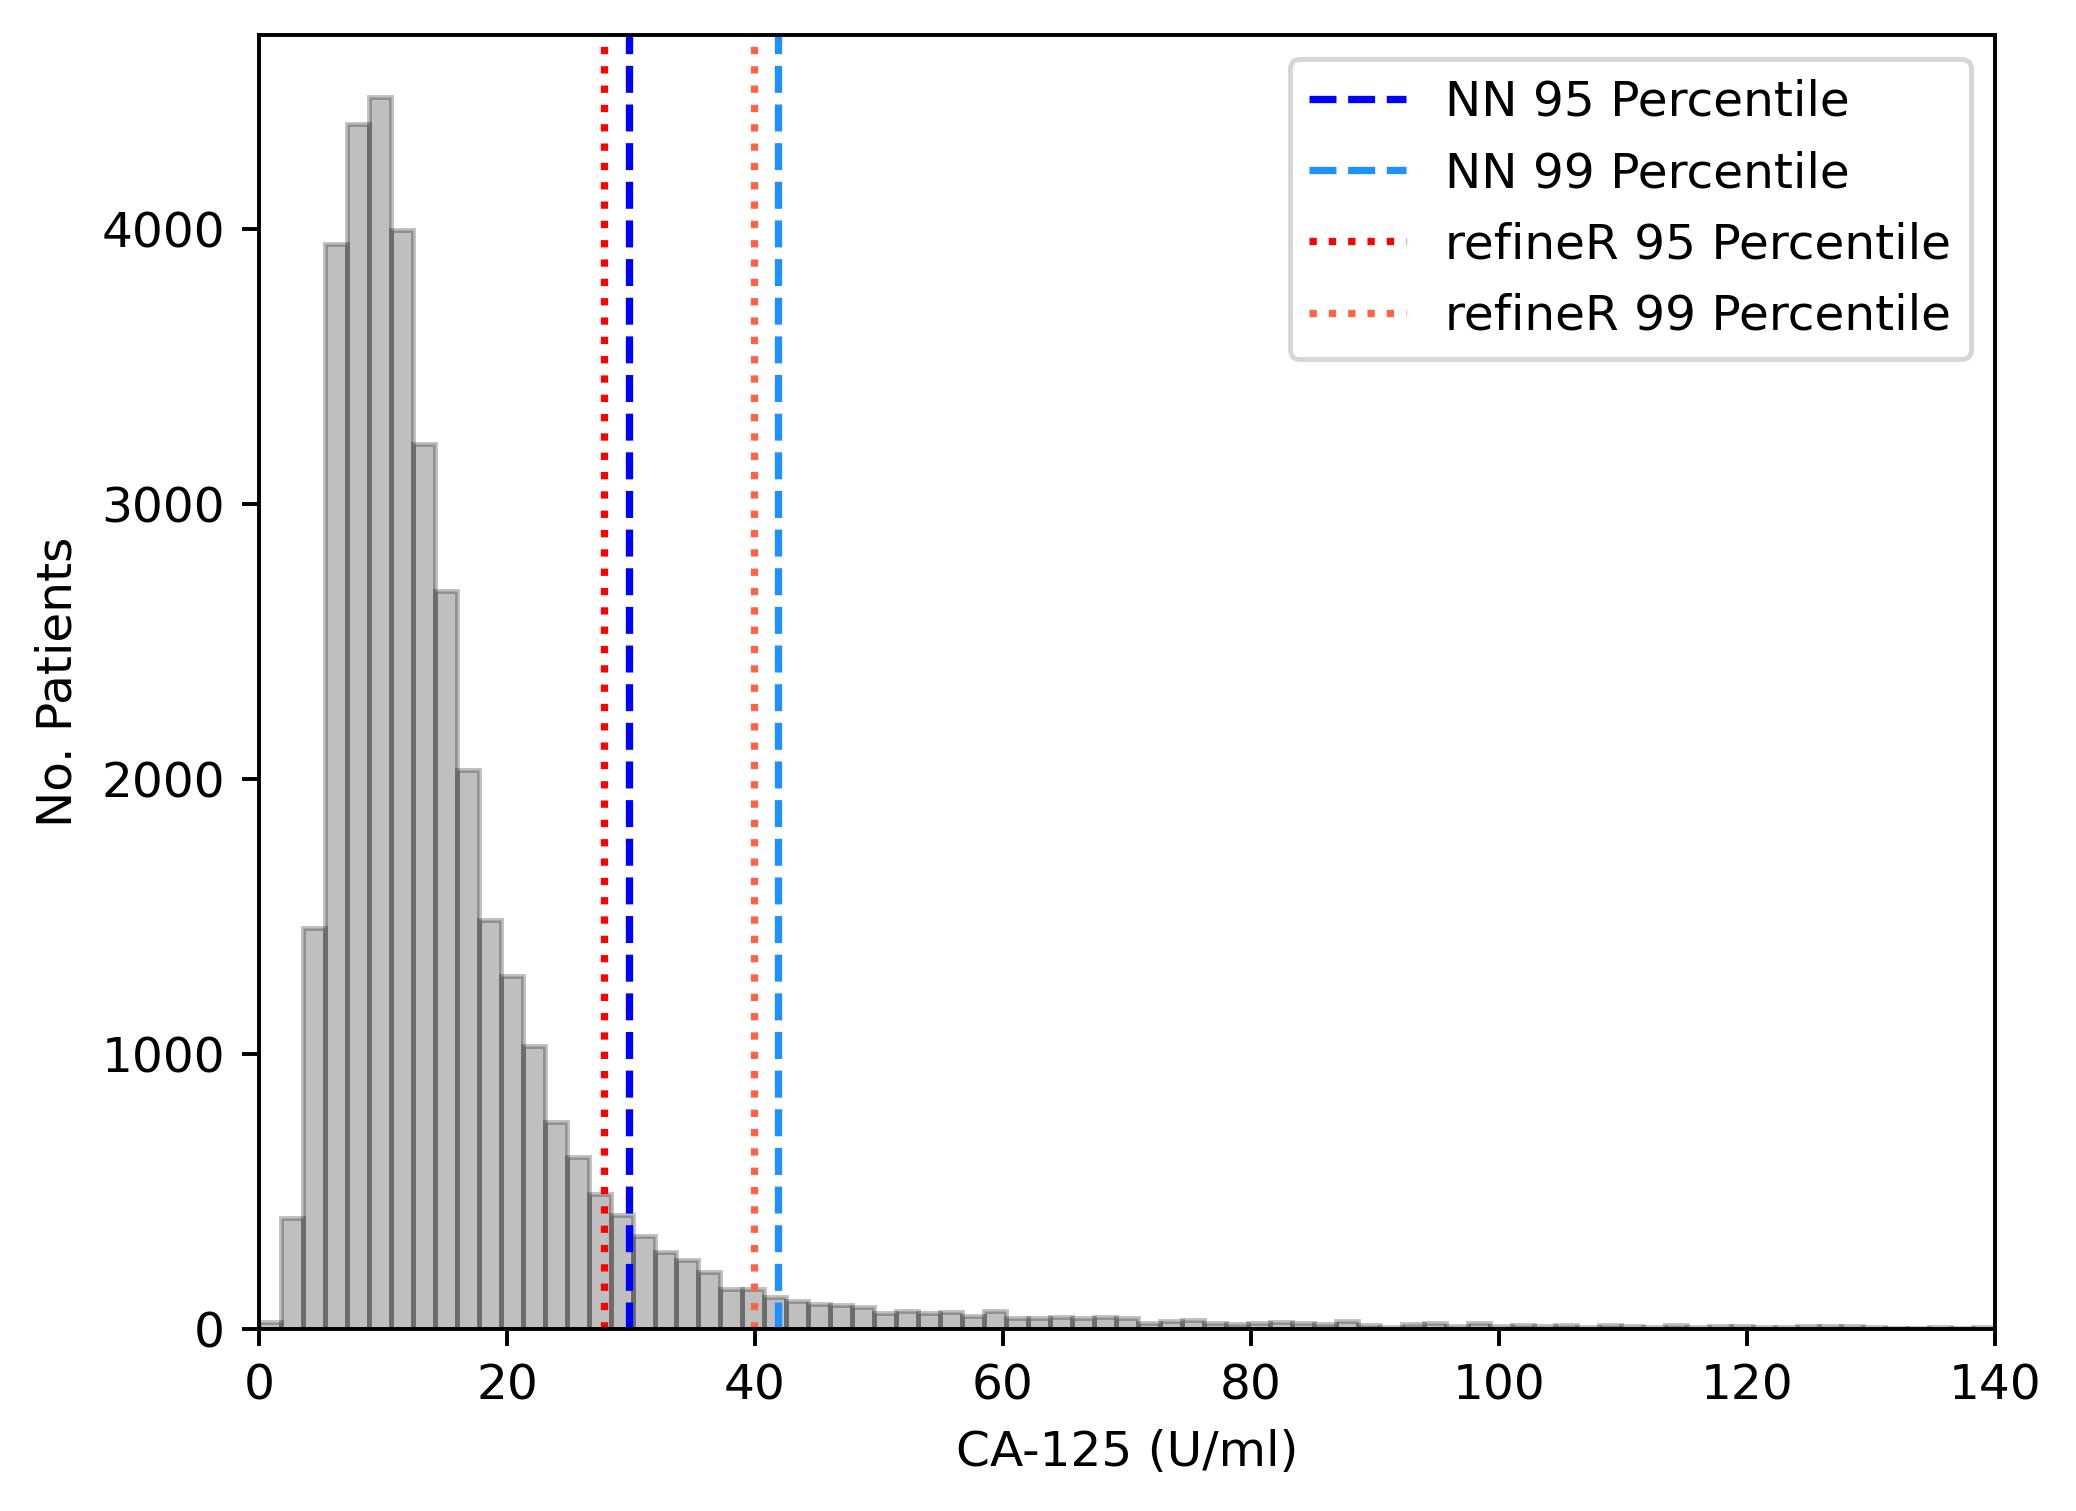

In [41]:
plt.figure(dpi=350)
# plot full dataset
plt.hist(df.value.values, np.linspace(0, 140, 80), edgecolor='k', color='k', alpha=0.25);

# plot NN predictions
plt.axvline(p95[0], c='b', label='NN 95 Percentile', linestyle='--')
plt.axvline(p99[0], c='dodgerblue', label='NN 99 Percentile', linestyle='--')

# plot refineR predictions
plt.axvline(rrp95.PointEst[1], c='r', label='refineR 95 Percentile', linestyle=':')
plt.axvline(rrp99.PointEst[1], c='tomato', label='refineR 99 Percentile', linestyle=':')

plt.xlabel('CA-125 (U/ml)')
plt.ylabel('No. Patients')
plt.legend();
plt.xlim([0, 140]);
